# Mixture models

In [13]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from IPython.display import Image, display

__version__ = '0.0.1'
__author__ = 'Denis Kuzin <denkuzin@yandex.ru>'

### intro

Recall types of clustering methods:
- hard clustering: clusters do not overlap
- soft clustering: clusters may overlap (**mixture models**)

Mixture models:
- probabilistically-grounded way of doing soft clustering (each cluster corresponds to probability distribution)
- each cluster: a generative model (Gaussian or multinomial)
- parameters  (mean/covariance are unknown)

#  Mixture models in 1-d

**Problem:**
There are observations $x_1,x_2,...,x_n$, $x_i \in R^1$
Half of them comes from gaussiana $a$, half of them comes from gaussiana $b$. For each $x_i$ we don't know source. **Q:** Estimate  parameters ($\mu_a$, $\sigma_a$) and ($\mu_b$, $\sigma_b$) of each gaussian.

**Expectation Maximization:**
1. start with random ($\mu_a$, $\sigma_a$) and ($\mu_b$, $\sigma_b$)

2. for each point, calculate $P(b|x_i)$ and $P(a|x_i)$ - probabilities that it look like it came from $b$-guassian and $a$-guassian:
<p><center></center></p>
$$
\left[ 
  \begin{align}
    P(a\ |\ x_i) & = \frac{P(x_i|a)P(a)}{P(x_i|a)P(a) + P(x_i|a)P(a)} \\
    P(b\ |\ x_i) & = \frac{P(x_i|b)P(b)}{P(x_i|a)P(a) + P(x_i|b)P(b)} \\
  \end{align}
  \right.
$$
<p><center>where, </center></p>
$$
\left[
  \begin{align}
    & P(a) = P(b) = 0.5\ \ \ \text{# the same number of observation}\\
    & P(x_i\ |\ a) = \frac{1}{\sqrt{2\pi\sigma_{a}^2}}exp(-\frac{(x_i-\mu)^2}{2\sigma_{a}^{2}})
    \ \ \ \text{#based on normal distribution} \\
    & P(x_i\ |\ b) = \frac{1}{\sqrt{2\pi\sigma_{b}^2}}exp(-\frac{(x_i-\mu)^2}{2\sigma_{b}^{2}}) \\
  \end{align}
  \right.
$$
<p><center></center></p>

3. adjust ($\mu_a$, $\sigma_a$) and ($\mu_b$, $\sigma_b$)
<p><center></center></p>
$$
\left[
    \begin{align}
        \mu_a & = \frac{\sum_{i=1}^{n}{P(a|x_i){\cdot}x_i}}
                {\sum_{i=1}^{n}{P(a|x_i)}} \\
        \mu_b & = \frac{\sum_{i=1}^{n}{P(b|x_i){\cdot}x_i}}
                {\sum_{i=1}^{n}{P(b|x_i)}} \\
        \sigma_a & = \frac{\sum_{i=1}^{n}{P(a|x_i){\cdot}(x_i-\mu_a)^2}}
                {\sum_{i=1}^{n}{P(a|x_i)}} \\
        \sigma_b & = \frac{\sum_{i=1}^{n}{P(b|x_i){\cdot}(x_i-\mu_b)^2}}
                {\sum_{i=1}^{n}{P(b|x_i)}} \\
     \end{align}\right.
$$
<p><center></center></p>
4. iterate until convergence


<br><br>
### Implementation

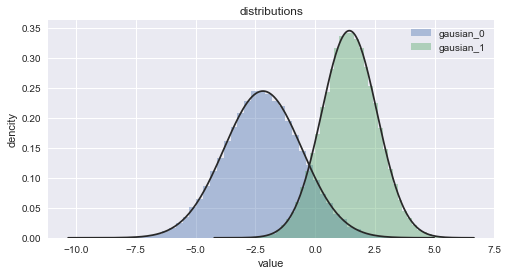

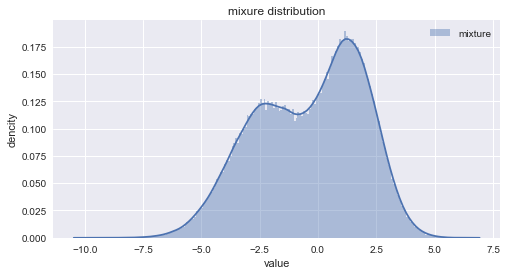

,names,mean,variance
0,gausian_0,-2.178052,2.646103
1,gausian_1,1.425756,1.333296


In [20]:
# generate notmally distributed 1-D vectors and mix up them

num_gaus = 2  # number of gaussians
num_examples_per_gaus = 100000
num_iterations = 50

feature = []
means = []
variances = []

for _ in range(num_gaus):
    mean = random.uniform(-10,10)
    means.append(mean)
    variance = random.uniform(1,5)
    variances.append(variance)
    means.sort()
    
for i in range(num_gaus):
    feat = np.random.normal(means[i], np.sqrt(variances[i]), size=(num_examples_per_gaus,))
    feature.append(feat)

feature_all = np.hstack(feature)

# visualization
fig = plt.figure(figsize=(8,4))
for i in range(num_gaus):
    sns.distplot(feature[i], bins = 50, hist = True, kde = False, 
                 fit=scipy.stats.norm, label="gausian_{}".format(i))
plt.title("distributions")
plt.xlabel("value")
plt.ylabel("dencity")
plt.legend(); 
plt.show()

fig = plt.figure(figsize=(8,4))
sns.distplot(feature_all, bins = 200, kde = True, label="mixture")
plt.title("mixure distribution")
plt.xlabel("value")
plt.ylabel("dencity")
plt.legend()
plt.show()

names = ["gausian_{}".format(i) for i in range(num_gaus)]
df = pd.DataFrame(list(zip(names, means, variances)), 
             columns=["names", "mean", "variance"])
df

initial values of mean = [-10.0, 10.0]
initial values of variance = [0.5, 1.0]


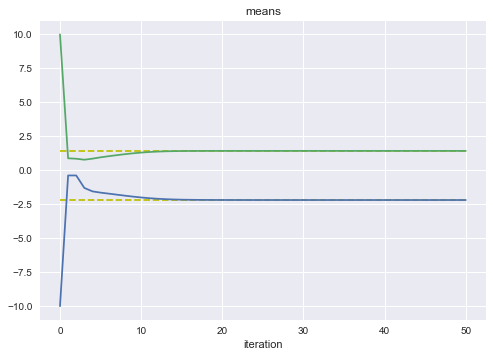

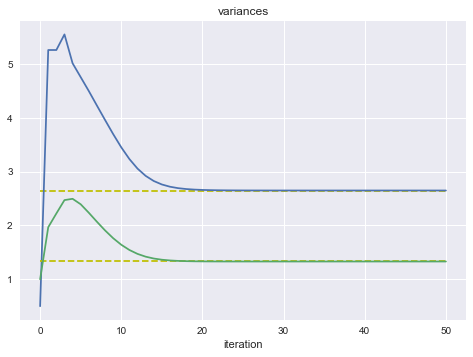

,names,means,means_est,means_error,variances,variance_est,variances_error
0,gausian_0,-2.178052,-2.186748,0.003993,2.646103,2.648534,0.000919
1,gausian_1,1.425756,1.428614,0.002004,1.333296,1.330244,0.002289


In [21]:
#1. initialisation of means and variances
num_clusters = num_gaus

means_est = np.linspace(-10,10,num = num_clusters).tolist()
variances_est = [a/2 for a in range(1, num_clusters+1)]
print ("initial values of mean = {}".format(means_est))
print ("initial values of variance = {}".format(variances_est))

#placeholders for probabilities the point to belong to cluster i
prob_cluster_x = [np.zeros(feature_all.shape)]*num_clusters
prob_x_cluster = [np.zeros(feature_all.shape)]*num_clusters

stats = []
stats.append((means_est.copy(), variances_est.copy()))

def probability_normal(feature, mean, variance):
    prefix = 1/np.sqrt(2*np.pi*variance)
    exp = np.exp(-((feature-mean)**2)/2/variance)   
    return prefix*exp

def conditional_probability(prob_x_cluster, i):
    numerator = (1.0/num_clusters)*prob_x_cluster[i]
    denominator = 0.5*np.sum(prob_x_cluster, axis=0)
    return numerator/denominator

def weighted_mean_and_var(p_cluster, feature):
    mean = np.sum(p_cluster * feature)/np.sum(p_cluster)
    var = np.sum(p_cluster * (feature - mean)**2)/np.sum(p_cluster)
    return mean, var

for _ in range(num_iterations):
    
    # 2. for each point calculate $P(cluster_i|x_i)$
    for i in range(num_clusters):
        prob_x_cluster[i] = probability_normal(
                    feature_all, means_est[i], variances_est[i])
        prob_cluster_x[i] = conditional_probability(prob_x_cluster, i)
    
    # 3. adjust means and variances
    for i in range(num_clusters):
        means_est[i], variances_est[i] = weighted_mean_and_var(
                prob_cluster_x[i], feature_all)
    
    stats.append((means_est.copy(), variances_est.copy()))     

names = ["gausian_{}".format(i) for i in range(num_gaus)]
means_error = [abs(a - b)/abs(a) for a,b in zip(means, means_est)]
variances_error = [abs(a - b)/abs(a) for a,b in \
                       zip(variances, variances_est)]

# visualization
for i in range(2*num_clusters):
    x_axis = list(range(len(stats)))
    targets = []
    estimats = []
    both_targets = means + variances
    
    for record in stats:
        both = record[0] + record[1]
        
        targets.append(both_targets[i])
        estimats.append(both[i])
    plt.plot(x_axis, targets, 'y--')
    plt.plot(x_axis, estimats)
    if i == num_clusters-1:
        plt.title("means")
        plt.xlabel("iteration")
        plt.show()
plt.title("variances")
plt.xlabel("iteration")
plt.show()

df = pd.DataFrame(
        list(zip(names, means, means_est, means_error, 
                 variances, variances_est, variances_error)), 
        columns=["names","means","means_est","means_error",
                 "variances","variance_est","variances_error"])
df

<br><br>
<br><br>



# Mixture models in k-d space

**Problem:**
There are observations $\vec{x_1},\vec{x_2},...,\vec{x_n}$, $\vec{x_i} \in R^k$. The same parts of observations come from gaussians $c$, all numbers of gaussians is $N$. For each $\vec{x_i}$ we don't know the source gaussian. **Q:** Estimate  parameters ($\vec{\mu_c}$, $\Sigma_{c}$)  for each gaussian $c$, $\vec{\mu_с} \in R^k$, $\Sigma_{c} \in S^{k}_{++}$

$k$ - dimensionality of $x_i$

**Expectation Maximization:**
1. start with random ($\vec{\mu_с}$, $\Sigma_{c}$) 

2. for each point, calculate $P(c|x_i)$ - probabilities that $\vec{x_i}$ cames from $c$-guassian:
<p><center></center></p>
$$
\begin{align} 
    P(c\ |\ x_i) = \frac{P(x_i|c)P(c)}
                    {\sum_{c=1}^{N}{P(x_i|c)P(c)}} \\
  \end{align}
$$
<p><center>where, </center></p>
$$
\left[
  \begin{align}
    & P(c) = \frac{1}{N}\ \ \ \text{# the same number of observation} \\
    & P(x_i\ |\ c) = \frac{1}{\sqrt{2\pi|\Sigma_{a}|}}
    exp\{-\frac{1}{2}(\vec{x_i} - \mu_c)^{T}\Sigma_{c}^{-1}(\vec{x_i} - \mu_c)\} \\
    & \Sigma_c = E[xx^T] -\mu_c\mu_{c}^T
  \end{align}\right.
$$
<p><center></center></p>

3. adjust ($\vec{\mu_c}$, $\Sigma_c$)
<p><center></center></p>
$$
\left[
    \begin{align} 
    & w_i = \frac{P(c|\vec{x_i})}{\sum_{i=1}^{n}{P(c|\vec{x_i})}}
    \\
    & \vec{\mu_c} = \sum_{i=1}^{n}{w_i\cdot\vec{x_i}} \\
    & \Sigma_c = \sum_{i=1}^{n}{[(w_i\vec{x_i} - \vec{\mu_c})\cdot(w_i\vec{x_i} - \vec{\mu_c})^{T}]}
     \end{align}\right.
$$
<p><center></center></p>

4. iterate until convergence


<br><br>




<br><br>




# Appendix

link_1: https://goo.gl/ErX1xN

link_2: https://goo.gl/cQaRNV

link_3: https://goo.gl/ZmpTSe

In [2]:
#paths = ["pics/pic1.png",
#         "pics/pic2.png",
#         "pics/pic3.png",
#         "pics/pic4.png",
#         "pics/pic5.png",
#         "pics/pic6.png"]
#images = []
#for path in paths:
#    images.append(Image(filename=path))
#display(*images)